In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/Bengali/valid_gray.zip /content/
!cp /content/drive/My\ Drive/Bengali/train_gen.csv /content/
!cp /content/drive/My\ Drive/Bengali/valid_gen.csv /content/
!cp /content/drive/My\ Drive/Bengali/Image_files.zip /content/

In [0]:
!pip uninstall tensorflow
!pip install tensorflow-gpu

In [46]:
import cv2
from tqdm import tqdm_notebook as tqdm
import os
import zipfile
import io
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.__version__

'2.1.0'

# Classifying Graheme Roots

In [0]:
!mkdir /content/valid_gray
!mv valid_gray.zip /content/valid_gray/
os.chdir('/content/valid_gray/')
!unzip valid_gray.zip

os.chdir('/content')

!mkdir /content/Image_files 
!mv Image_files.zip /content/Image_files/
os.chdir('/content/Image_files/')
!unzip Image_files.zip

os.chdir('/content')

In [0]:
train_gen_df = pd.read_csv('train_gen.csv')
valid_gen_df = pd.read_csv('valid_gen.csv')

### 167 unique target classes to train on

[]

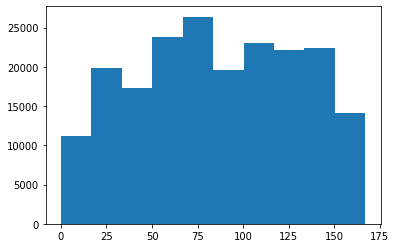

In [59]:
plt.hist(train_gen_df['class'])
plt.plot()

### class imbalance detected!!!!

[]

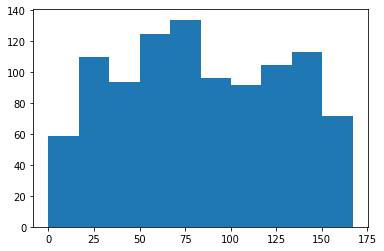

In [58]:
plt.hist(valid_gen_df['class'])
plt.plot()

In [0]:
from tensorflow.keras.layers import Dense,BatchNormalization,Input,Dropout,Conv2D,Flatten,MaxPool2D,LeakyReLU # keras layers
from tensorflow.keras.models import Model #Model class
from tensorflow.keras.optimizers import Adam #optimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

In [0]:
inputs = Input(shape = (256, 256, 1))
model = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(inputs)
model = LeakyReLU(alpha=0.17)(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2,2))(model)

model = Conv2D(filters=64, kernel_size=(5,5), activation='relu')(model)
model = LeakyReLU(alpha=0.17)(model)
model = BatchNormalization(momentum=0.15)(model)
model = MaxPool2D(pool_size=(2,2))(model)

model = Flatten()(model)
model = Dense(512)(model)
model = LeakyReLU()(model)
model = Dropout(rate=0.35)(model)
model = BatchNormalization(momentum=0.15)(model)
model = Dropout(rate=0.3)(model)
dense = Dense(192, activation = "relu")(model) 

out1 = Dense(168, activation = 'softmax',name='out_1')(dense)

model = Model(inputs=inputs, outputs=out1)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_out_1_loss',patience=3,verbose=1,factor=0.5,min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss',patience=4, min_delta=0.0025,restore_best_weights=True)
checkpoints = ModelCheckpoint('best_model_weight.h5', monitor ='val_loss', verbose =1, save_best_only = True, save_weights_only=True)
callbacks = [lr_reducer,early_stop,checkpoints]

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(
dataframe=train_gen_df,
directory="./train_gray/",
x_col="images",
y_col="class",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(256, 256))

valid_generator=datagen.flow_from_dataframe(
dataframe=train_gen_df,
directory="./train_gray/",
x_col="images",
y_col="class",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(256, 256))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=valid_gen_df,
directory="./valid_gray/",
x_col="images",
y_col="class",
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(256, 256))

TypeError: ignored

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4683 steps, validate for 1561 steps
Epoch 1/10
   1/4683 [..............................] - ETA: 5:18

NotFoundError: ignored